Epoch 0, Loss: [[1.0831449]]
Epoch 100, Loss: [[0.00055233]]
Epoch 200, Loss: [[0.0001868]]
Epoch 300, Loss: [[6.834269e-05]]
Epoch 400, Loss: [[3.329991e-05]]
Epoch 500, Loss: [[2.2159253e-05]]
Epoch 600, Loss: [[1.6691718e-05]]
Epoch 700, Loss: [[1.2888049e-05]]
Epoch 800, Loss: [[1.0011821e-05]]
Epoch 900, Loss: [[7.847386e-06]]


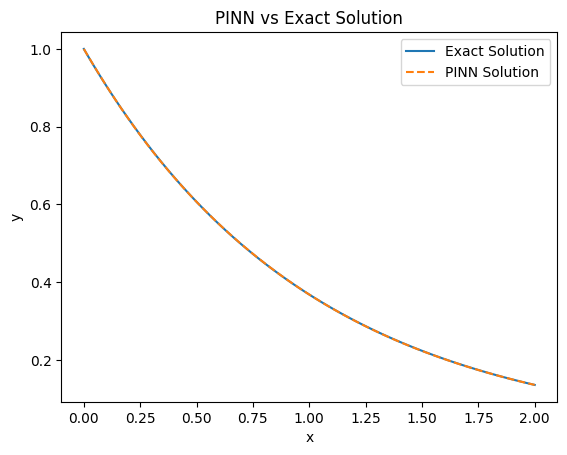

In [1]:
import tensorflow as tf
import numpy as np

# Definir la red neuronal
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(10, activation='tanh')
        self.hidden_layer2 = tf.keras.layers.Dense(10, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        return self.output_layer(x)

# Definir la pérdida basada en la ecuación diferencial
def compute_loss(model, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)
    dy_dx = tape.gradient(y, x)  # Derivada de y con respecto a x
    ode_loss = tf.reduce_mean(tf.square(dy_dx + y))  # Ecuación diferencial
    ic_loss = tf.square(model(tf.constant([[0.0]])) - 1.0)  # Condición inicial
    return ode_loss + ic_loss

# Generar datos para entrenamiento (x entre 0 y 2)
x_train = tf.constant(np.linspace(0, 2, 100).reshape(-1, 1), dtype=tf.float32)

# Inicializar el modelo y el optimizador
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Entrenamiento
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x_train)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Evaluar la solución
x_test = tf.constant(np.linspace(0, 2, 100).reshape(-1, 1), dtype=tf.float32)
y_pred = model(x_test).numpy()

# Comparar con la solución exacta
import matplotlib.pyplot as plt

y_exact = np.exp(-x_test.numpy())
plt.plot(x_test.numpy(), y_exact, label="Exact Solution")
plt.plot(x_test.numpy(), y_pred, '--', label="PINN Solution")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN vs Exact Solution")
plt.show()

Epoch 0, Loss: [[13.762507]]
Epoch 200, Loss: [[0.01217206]]
Epoch 400, Loss: [[0.00801771]]
Epoch 600, Loss: [[0.00664448]]
Epoch 800, Loss: [[0.00651266]]
Epoch 1000, Loss: [[0.00650764]]
Epoch 1200, Loss: [[0.00650665]]
Epoch 1400, Loss: [[0.00650565]]
Epoch 1600, Loss: [[0.00650458]]
Epoch 1800, Loss: [[0.00650344]]


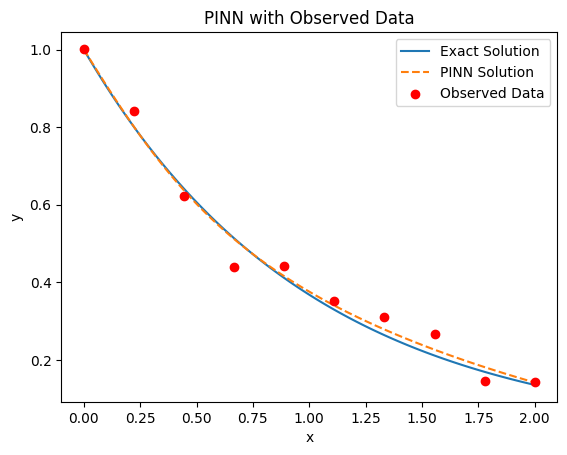

In [2]:
import tensorflow as tf
import numpy as np

# Definir la red neuronal
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(10, activation='tanh')
        self.hidden_layer2 = tf.keras.layers.Dense(10, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        return self.output_layer(x)

# Generar datos observados cercanos a la solución exacta
np.random.seed(610014)
x_data = np.linspace(0, 2, 10).reshape(-1, 1)
y_exact = np.exp(-x_data)  # Solución exacta
y_data = y_exact + 0.05 * np.random.normal(size=y_exact.shape)  # Añadir ruido

x_data_tf = tf.constant(x_data, dtype=tf.float32)
y_data_tf = tf.constant(y_data, dtype=tf.float32)

# Definir la pérdida basada en la ecuación diferencial, la condición inicial y los datos observados
def compute_loss(model, x, x_data, y_data, alpha=1.0, beta=1.0, gamma=1.0):
    # Ecuación diferencial
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)
    dy_dx = tape.gradient(y, x)
    ode_loss = tf.reduce_mean(tf.square(dy_dx + y))  # Pérdida ODE

    # Condición inicial
    ic_loss = tf.square(model(tf.constant([[0.0]])) - 1.0)  # Condición inicial

    # Datos observados
    y_pred_data = model(x_data)
    data_loss = tf.reduce_mean(tf.square(y_pred_data - y_data))  # Pérdida por datos

    # Combinación de pérdidas con pesos
    total_loss = alpha * ode_loss + beta * ic_loss + gamma * data_loss
    return total_loss

# Generar datos para entrenamiento (x entre 0 y 2)
x_train = tf.constant(np.linspace(0, 2, 100).reshape(-1, 1), dtype=tf.float32)

# Inicializar el modelo y el optimizador
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Entrenamiento
for epoch in range(2000):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x_train, x_data_tf, y_data_tf, alpha=1.0, beta=10.0, gamma=5.0)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Evaluar la solución
x_test = tf.constant(np.linspace(0, 2, 100).reshape(-1, 1), dtype=tf.float32)
y_pred = model(x_test).numpy()

# Comparar con la solución exacta y los datos observados
import matplotlib.pyplot as plt

plt.plot(x_test.numpy(), np.exp(-x_test.numpy()), label="Exact Solution")
plt.plot(x_test.numpy(), y_pred, '--', label="PINN Solution")
plt.scatter(x_data, y_data, color="red", label="Observed Data", zorder=5)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN with Observed Data")
plt.show()

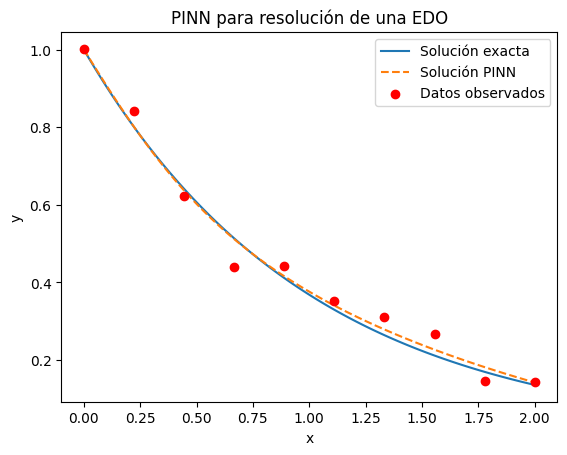

In [4]:
plt.plot(x_test.numpy(), np.exp(-x_test.numpy()), label="Solución exacta")
plt.plot(x_test.numpy(), y_pred, '--', label="Solución PINN")
plt.scatter(x_data, y_data, color="red", label="Datos observados", zorder=5)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN para resolución de una EDO")
plt.show()